In [2]:
from transformers import GPT2Tokenizer, GPTNeoForCausalLM, GPT2TokenizerFast
from transformers import pipeline
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import csv
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = "cuda:0"
model_id = "EleutherAI/gpt-neo-2.7B"
model = GPTNeoForCausalLM.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)


In [6]:
data = pd.read_csv('/nas/home/gujiashe/trans/yago310_top10_predictions.tsv', sep="\t", header=0, index_col=0)
perplexities = []
cnt = 0
for head, relation, pred_tail, true_tail, rank, score in tqdm(data.to_numpy()):
    head = " ".join(head.split("_"))
    relation = re.sub( r"([A-Z])", r" \1", relation).lower()
    # print(relation)
    pred_tail = " ".join(pred_tail.split("_"))
    true_tail = " ".join(true_tail.split("_"))
    sentence = " ".join([head, relation, pred_tail])
#     sentence = "5) " + ", ".join([head, relation, pred_tail]) + ": "
#     sample = "1) Paris, isLocatedIn, France: Paris is located in France.\n\
# 2) John, notGo, Brazil: Joes does not go to Brazil.\n\
# 3) Computer, madeOf, plastic: Computer is made of plastic.\n\
# 4) Carl_Jung, influences, psychology: Carl_Jung has influence on psychology.\n"
#     sample = sample + sentence
#     print(sample)
    # input_ids = tokenizer(sample, return_tensors="pt").input_ids
    # input_ids = input_ids.to(device)

    # # expect_ids = tokenizer(expect_final, return_tensors="pt").input_ids
    # # expect_ids = expect_ids.to(device)
    # # max_new_tokens = expect_ids.shape[1]



    # gen_output = model.generate(
    # input_ids,
    # # do_sample=True,
    # # temperature=0.9,
    # # max_new_tokens = max_new_tokens,
    # max_length = 1000,
    # return_dict_in_generate = True,
    # output_scores = True,
    # pad_token_id = model.config.eos_token_id,
    # eos_token_id = 198
    # )
    # gen_tokens = gen_output.sequences
    # gen_scores = gen_output.scores
    # gen_text = tokenizer.batch_decode(gen_tokens)[0]

    # gen_scores = torch.stack(list(gen_scores), dim=0).squeeze(1)
    # print(gen_text.split(":")[-1])
    # sentence = gen_text.split(":")[-1]

    input_ids = tokenizer(sentence, return_tensors="pt").input_ids
    # print(sentence)
    # print(input_ids)
    
    max_length = model.config.max_position_embeddings
    stride = 512

    nlls = []
    for i in range(0, input_ids.size(1), stride):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = min(i + stride, input_ids.size(1))
        trg_len = end_loc - i  # may be different from stride on last loop
        input_ids = input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs[0] * trg_len

        nlls.append(neg_log_likelihood)

    ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
    perplexities.append(ppl.detach().cpu().item())
    # break
    # cnt+=1
    # if cnt>10:
    #     break



100%|██████████| 49820/49820 [41:01<00:00, 20.24it/s] 


In [7]:
data["ppls"] = perplexities
data["ppls"]

0         33.579117
1         34.855797
2         14.953859
3         28.094059
4         61.268936
            ...    
49815     78.989479
49816     87.370079
49817    108.237167
49818     75.708755
49819    267.057861
Name: ppls, Length: 49820, dtype: float64

In [8]:
data.to_csv('yago310_ppls_top10_gpt.tsv', sep="\t")

In [9]:
data = pd.read_csv('/nas/home/gujiashe/trans/yago310_ppls_top10_gpt.tsv', sep="\t", header=0, index_col=0)
data = data[['rank', "ppls"]]

6
5
1


Text(0, 0.5, 'ppl')

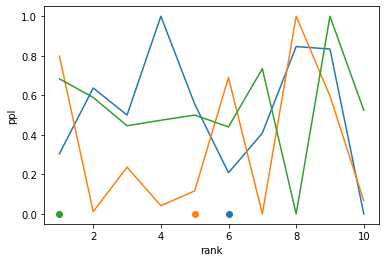

In [10]:
vis = set()
for index in range(0, 5):
    if data["rank"][index*10]>10 or data["rank"][index*10] in vis:
        continue
    vis.add(data["rank"][index*10])
    print(data["rank"][index*10])
    plt.scatter(data["rank"][index*10], 0)
    df = data['ppls'][index*10:index*10 + 10]
    normalized_df=(df-df.min())/(df.max()-df.min())
    plt.plot([i for i in range(1, 11)], normalized_df)
plt.xlabel("rank")
plt.ylabel("ppl")

In [11]:
perplexities = []
cnt = 0
data4sent = pd.read_csv('/nas/home/gujiashe/trans/yago310_top10_predictions.tsv', sep="\t", header=0, index_col=0)
sentences = []
pair = []
for head, relation, pred_tail, true_tail, rank, score in tqdm(data4sent.to_numpy()):
    head = " ".join(head.split("_"))
    relation = re.sub( r"([A-Z])", r" \1", relation).lower()
    pred_tail = " ".join(pred_tail.split("_"))
    true_tail = " ".join(true_tail.split("_"))
    sentence = " ".join([head, relation, pred_tail])

    # pair.append(sentence)
    # if cnt%2==1:
    #     pair = [0]+pair
    
    
    len_all = len(sentence.split(" "))
    len_pred = len(pred_tail.split(" "))

    sentences.append([str(len_all-1-len_pred) + " " +  str(len_all-1)] + [sentence])
        # pair = []

    cnt+=1
    # if cnt>10:
    #     break




100%|██████████| 49820/49820 [00:00<00:00, 85309.28it/s] 


In [12]:
pd.DataFrame(sentences).to_csv('knowbert_ppl_top10.tsv', sep="\t", header=None, index = None)

In [43]:
# preplexities = []
# for head, relation, pred_tail, true_tail, rank in data.to_numpy():
#     head = " ".join(head.split("_"))
#     pred_tail = " ".join(pred_tail.split("_"))
#     true_tail = " ".join(true_tail.split("_"))
#     sentence = " ".join([head, relation, true_tail])
#     input_ids = tokenizer(sentence, return_tensors="pt").input_ids
#     print(sentence)
#     print(input_ids)
#     max_length = model.config.max_position_embeddings
#     stride = 512

#     nlls = []
#     for i in tqdm(range(0, input_ids.size(1), stride)):
#         begin_loc = max(i + stride - max_length, 0)
#         end_loc = min(i + stride, input_ids.size(1))
#         trg_len = end_loc - i  # may be different from stride on last loop
#         input_ids = input_ids[:, begin_loc:end_loc].to(device)
#         target_ids = input_ids.clone()
#         target_ids[:, :-trg_len] = -100

#         with torch.no_grad():
#             outputs = model(input_ids, labels=target_ids)
#             neg_log_likelihood = outputs[0] * trg_len

#         nlls.append(neg_log_likelihood)

#     ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
#     preplexities.append(ppl)
#     break
# ppl

Stan Collymore playsFor England national football team
tensor([[32140,   327,  5098,  3549,  5341,  1890,  4492,  2260,  4346,  1074]])


100%|██████████| 1/1 [00:00<00:00, 33.26it/s]


tensor(211.6765, device='cuda:0')

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-2.7B")
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-2.7B")
device = torch.device('cuda:0')
model.to(device)

In [ ]:
class MeanReciprocalRank:
    def __init__(self):
        self._sum = 0.0
        self._n = 0.0

    def __call__(self, predictions, labels):
        # Flatten
        labels = labels.view(-1)
        
        predictions = predictions.view(labels.shape[0], -1)

        
        # MRR computation
        label_scores = predictions.gather(-1, labels.unsqueeze(-1))
        rank = predictions.ge(label_scores).sum(1).float()
        # print(rank)
        reciprocal_rank = 1 / rank
        self._sum += (reciprocal_rank).sum().item()
        self._n += len(labels)

    def get_metric(self, reset=False):
        mrr = self._sum / (self._n + 1e-13)
        if reset:
            self.reset()
        return mrr
    def reset(self):
        self._sum = 0.0
        self._n = 0.0
class Hits:
    def __init__(self, topn):
        self.topn = topn
        self._sum = 0.0
        self._n = 0.0

    def __call__(self, predictions, labels):
        # Flatten
        labels = labels.view(-1)

        predictions = predictions.view(labels.shape[0], -1)


        # MRR computation
        label_scores = predictions.gather(-1, labels.unsqueeze(-1))
        rank = predictions.ge(label_scores).sum(1).float()
        # reciprocal_rank = 1 / rank
        score = rank.le(self.topn).float()
        self._sum += (score).sum().item()
        self._n += len(labels)

    def get_metric(self, reset=False):
        hits = self._sum / (self._n + 1e-13)
        if reset:
            self.reset()
        return hits

    def reset(self):
        self._sum = 0.0
        self._n = 0.0


In [127]:
import datetime
import csv
s_list = []
birth_property = "date"
with open('birth_table1.tsv', 'r') as t:
    i = 0
    # sentences_birth = open("sentences_birth.tsv", "w")
    # tsv_writer = csv.writer(sentences_birth, delimiter='\t')

    for line in t:
        i+=1
        if i==1:
            continue
        
        person, mother, place, date = line.split('\t')
        if len(mother) == 0:
            continue
        def process(raw):
            raw = raw.split("@")
            content, lang = raw
            content = content.strip("''").split()
            return content, lang

        person, lang = process(person)
        if lang != "en":
            continue
        mother, lang = process(mother)
        if lang != "en":
            continue        
        place, lang = process(place)
        if lang != "en":
            continue
        
        date = date.split('T')[0][1:]
        year, month, day = date.split('-')
        year = int(year)
        month = int(month)
        day = int(day)
        d = datetime.date(year, month, day)
        date = d.strftime("%d %B %Y").split()

        # sentence = mother + ["gave", "birth", "to"] + person + ["on"] + date + ['.']
        # sentence = " ".join(sentence)
        sentence = ""
        expect = ""
        if birth_property == "place":
            inference = person + ["was", "born", "in"] + place + ['.']
            expect = place
        elif birth_property == "mother":
            inference = person + ["'s", "mother"] + ["is"] + mother + ['.']
            expect = mother
        elif birth_property == "person":
            inference = mother + ["gave", "birth", "to"] + person + ['.']
            expect = person
        elif birth_property == "date":
            inference = mother + ["gave", "birth", "to"] + person + ["on"] + date +['.']
            expect = date
        inference = " ".join(inference)

        s_expect = " ".join(expect)
        s_list.append("\t".join([sentence + '\n' + inference, s_expect]))
        # print("person: ", person,  "mother: ", mother, "place: ", place, "date: ", date, len(place), len(date))
        # “[MOTHER] gave birth to [PERSON] at [PLACE] on [DATE]” 

        # idx = 0
        # spans = []
        # spans.append([idx, idx + len(mother) - 1])
        # idx+=len(mother) + 3
        # spans.append([idx, idx + len(person) - 1])
        # idx+=len(person) + 1
        # spans.append([idx, idx + len(place) - 1])
        # idx+=len(place) + 1

        # date = date.split('T')[0][1:]
        # year, month, day = date.split('-')
        # year = int(year)
        # month = int(month)
        # day = int(day)
        # d = datetime.date(year, month, day)
        # date = d.strftime("%d %B %Y").split()
        # spans.append([idx, idx + 2])
        
        # s = mother + ["gave", "birth", "to"] + person + ["at"] + place + ["on"] + date + ["."]
        # s = " ".join(s)
        # for span in spans:
        #     tsv_writer.writerow([str(span[0]) + " " +  str(span[1])] + [s])
        # print(spans)
        # print(s)
        # if i>10:
        #     breaks
    # sentences_birth.close()
    # print(i)
s_list[0]


'\nSelina Keagon gave birth to Cornelius Tuayan Keagon on 06 July 1996 .\t06 July 1996'

In [130]:
import random
sample_num = 6


spreadsheet_gptneo = open(birth_property+"_spreadsheet_gptneo.tsv", "w")
tsv_writer = csv.writer(spreadsheet_gptneo, delimiter='\t')
mrr = MeanReciprocalRank()
hits1 = Hits(1)
hits10 = Hits(10)
hits50 = Hits(50)

total_ranks = []
for _ in tqdm(range(1000)):
    sample_ids = random.sample(range(len(s_list)), sample_num)
    sample = ""
    expect_final = ""
    for i, sample_id in enumerate(sample_ids):
        sentence, expect = s_list[sample_id].split('\t')
        sentence, inference = sentence.split('\n')
        len_expect = len(expect.split())
        words = inference.split()
        if i == sample_num-1:
            expect_final = " "+expect
            sentence = "{})".format(i+1) + sentence + '\n' + " ".join(words[:-1-len_expect])
        else:
            sentence = "{})".format(i+1) + sentence + '\n' + " ".join(words) + '\n'
        sample += sentence
    # sample = "1)Frances Ford Seymour gave birth to Jayne Seymour Fonda on 21 December 1937.\
    #         Jayne Seymour Fonda was born in New York City.\
    #         2)Sylvana Windsor, Countess of St Andrews gave birth to Amelia Sophia Theodora Mary Margaret Windsor on 24 August 1995.\
    #         Amelia Sophia Theodora Mary Margaret Windsor was born in Rosie Hospital.\
    #         3)Jane Hawker gave birth to Frances Anne Seymour on 14 August 1807.\
    #         Frances Anne Seymour was born in Plymouth.\
    #         4)Anne Mary Stephen gave birth to Albert Venn Dicey on 04 February 1835.\
    #         Albert Venn Dicey was born in Claybrooke Magna.\
    #         5)Edith Mawd Thomas gave birth to Richard Walter Jenkins on 10 November 1925.\
    #         Richard Walter Jenkins was born in Pontrhydyfen.\
    #         6)Katherine Chamberlain gave birth to Elizabeth Harman on 30 August 1906.\
    #         Elizabeth Harman was born in"
    # expect_final = " London"
    # len_expect = len(expect_final.split())

    # input_ids = len(tokenizer.tokenize(sample))
    # generated_text = generator(sample, do_sample=True, max_length=input_ids+5)[0]["generated_text"]
    input_ids = tokenizer(sample, return_tensors="pt").input_ids
    input_ids = input_ids.to(device)

    expect_ids = tokenizer(expect_final, return_tensors="pt").input_ids
    expect_ids = expect_ids.to(device)
    max_new_tokens = expect_ids.shape[1]


    gen_output = model.generate(
    input_ids,
    # do_sample=True,
    # temperature=0.9,
    max_new_tokens = max_new_tokens,
    # max_length = 100,
    return_dict_in_generate = True,
    output_scores = True,
    pad_token_id = model.config.eos_token_id
)
    gen_tokens = gen_output.sequences
    gen_scores = gen_output.scores
    gen_text = tokenizer.batch_decode(gen_tokens)[0]
    
    gen_scores = torch.stack(list(gen_scores), dim=0).squeeze(1)

    mrr(gen_scores, expect_ids)
    hits1(gen_scores, expect_ids)
    hits10(gen_scores, expect_ids)
    hits50(gen_scores, expect_ids)
    

    ranks = torch.argsort(gen_scores, dim = 1, descending=True)
    ranks = torch.argsort(ranks, dim = 1)
    gen_ranks = [ranks[i][id].item() for i, id in enumerate(expect_ids[0])]
    # print(expect_final)
    # print(expect_ids)
    # print(len_expect, max_new_tokens)
    
    expect_generate = " ".join(gen_text.split()[-len_expect:])
    # expect_generate = gen_text.split("was born in")[-1]

    total_ranks += gen_ranks
    gen_ranks = list(map(str, gen_ranks))
    gen_ranks = ",".join(gen_ranks)
    # break

    # print([gen_text, expect_final, expect_generate, gen_ranks])
    # print(torch.argmax(gen_scores, dim = 1))

    tsv_writer.writerow([gen_text, expect_final, expect_generate, gen_ranks])
    # break
spreadsheet_gptneo.close()

print("mrr: ", mrr.get_metric())
print("hits@1: ", hits1.get_metric())
print("hits@10: ", hits10.get_metric())
print("hits@50: ", hits50.get_metric())
print(sample)
        

100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]

mrr:  0.20700720993675967
hits@1:  0.10706703063390961
hits@10:  0.462238398544131
hits@50:  0.86472550803761
1)
Christian Clark gave birth to James Clark Ross on 15 April 1800 .
2)
Christine Ann Assange gave birth to Julian Paul Hawkins on 03 July 1971 .
3)
Maria Shriver gave birth to Patrick Arnold Shriver Schwarzenegger on 18 September 1993 .
4)
AnnMaria De Mars gave birth to Ronda Jean Rousey on 01 February 1987 .
5)
Jaddanbai gave birth to Fatima Rashid on 01 June 1929 .
6)
Mary Henn gave birth to Charles Villiers Stanford on


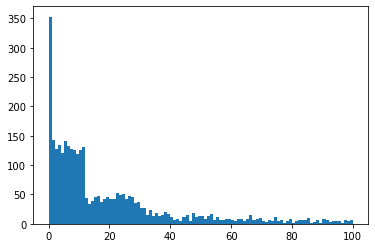

In [131]:
import matplotlib.pyplot as plt
plt.hist(total_ranks, bins = 100, range = [0, 100])
plt.savefig(birth_property+'_gptneo.jpg')
plt.show()

In [123]:
s_list

["\nCornelius Tuayan Keagon 's mother is Selina Keagon .\tSelina Keagon",
 "\nFrederick Austerlit 's mother is Ann Astaire .\tAnn Astaire",
 "\nAndrew Barron Murray 's mother is Judy Murray .\tJudy Murray",
 "\nThe Honourable Louis Charles Alexander Herbert 's mother is Victoria Herbert, Countess of Pembroke .\tVictoria Herbert, Countess of Pembroke",
 "\nSusan Alexandra Weaver 's mother is Elizabeth Inglis .\tElizabeth Inglis",
 "\nElias Lafayette Rinehart 's mother is Sarah Rinehart .\tSarah Rinehart",
 "\nLady Olympia Arabella Kitty Spencer-Churchill 's mother is Camilla Thorp .\tCamilla Thorp",
 "\nGeorge Evelyn Augustus Townley Sothern 's mother is Frances Emily Stewart .\tFrances Emily Stewart",
 "\nRichard Buckminster Fuller 's mother is Caroline Wolcott Andrews .\tCaroline Wolcott Andrews",
 "\nFarrah Leni Fawcett 's mother is Pauline Alice Evans .\tPauline Alice Evans",
 "\nDonald McLennan 's mother is Janet Ross .\tJanet Ross",
 "\nJames Maitland Stewart 's mother is Elizabet

In [12]:
'''

Generate an inference 

Requires: 
    Select an event, relation, and top_p if sampling (leaving it at 0. will 
    use greedy decoding)

'''

####
# Parameters
####

# input event to generate for
event = 'PersonX eats less'
# one of ['xEffect','xAttr','xReact', 'xWant','xIntent', 'xNeed', 'HinderedBy']
relation = 'xEffect'
# top_p
top_p = 0.0



####
# Generate, using parameters
####

inp_text = "<head> {} </head> <relation> {} </relation> [GEN] ".format(event.strip(),relation)
inp = tokenizer(inp_text)['input_ids']
tokens_out = model.generate(torch.tensor(inp).view(1,-1).to(device),top_p=top_p, do_sample=top_p > 0.).tolist()[0]
text_out = tokenizer.decode(tokens_out)

## trim to sentence end and/or newline
if '.' in text_out:
    text_out = text_out[:text_out.index('.')]
if '\n' in text_out:
    text_out = text_out[:text_out.index('\n')]

# finally, trim out only the inference
inference = text_out[text_out.index('[GEN]')+6:]


####
# Print Result
####

print('INPUT:\n{}\n========'.format(inp_text))
print('INFERENCE:\n{}\n========'.format(inference))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 22, but ``max_length`` is set to 20.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


INPUT:
<head> PersonX eats less </head> <relation> xEffect </relation> [GEN] 
INFERENCE:



In [104]:
for k,v in tokenizer.vocab.items():
    if v==7309:
        print(k ,v)
    if k==')':
        print(k ,v)

Ġplastic 7309
) 8


In [76]:
model.config.eos_token_id

50256

In [123]:
sample = "1) Paris, located in, France: Paris is located in France.\n\
2) John, no go, Brazil: Joes does not go to Brazil.\n\
3) Computer, made of, plastic: Computer is made of plastic.\n\
4) Stan_Collymore, playsFor, Leicester_City_F.C.: "
print(sample)
input_ids = tokenizer(sample, return_tensors="pt").input_ids
input_ids = input_ids.to(device)

# expect_ids = tokenizer(expect_final, return_tensors="pt").input_ids
# expect_ids = expect_ids.to(device)
# max_new_tokens = expect_ids.shape[1]
max_new_tokens = 11


gen_output = model.generate(
input_ids,
# do_sample=True,
# temperature=0.9,
# max_new_tokens = max_new_tokens,
max_length = 1000,
return_dict_in_generate = True,
output_scores = True,
pad_token_id = model.config.eos_token_id,
eos_token_id = 198
)
gen_tokens = gen_output.sequences
gen_scores = gen_output.scores
gen_text = tokenizer.batch_decode(gen_tokens)[0]

gen_scores = torch.stack(list(gen_scores), dim=0).squeeze(1)
print(gen_text.split(":")[-1])

1) Paris, located in, France: Paris is located in France.
2) John, no go, Brazil: Joes does not go to Brazil.
3) Computer, made of, plastic: Computer is made of plastic.
4) Stan_Collymore, playsFor, Leicester_City_F.C.: 
  Stan_Collymore plays for Leicester City F.C.



In [95]:
gen_tokens

tensor([[   16,     8,  6342,    11,  5140,   287,    11,  4881,    25,  6342,
           318,  5140,   287,  4881,    13,   198,    17,     8,  1757,    11,
           645,   467,    11,  7595,    25,   449,  3028,   857,   407,   467,
           284,  7595,    13,   198,    18,     8, 13851,    11,   925,   286,
            11,  7309,    25, 13851,   318,   925,   286,  7309,    13,   198,
            19,     8,  4422,    62,  3041, 29333,    11,   318, 35191, 31705,
          2514,    11, 12958, 49325,    62,    54,   392, 19288,    62,    37,
            13,    34, 11207,   220,  4422,    62,  3041, 29333,   318, 18552,
           284, 12958, 49325, 22420, 19288,   376,    13]], device='cuda:0')

In [ ]:
# generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device = 6)
# test_s = "1) Barack Obama was born in Honolulu.\n2) Angela Merkel was born in Berlin.\n3) John Lennon was born in liverpool\n4) Donald Trump was born in New York\n5) Joe Biden was born in Pennsylvania\n6) Clinton was born in"
# print(test_s)
# len(tokenizer.tokenize(test_s))
# generated = generator(test_s, do_sample=True, max_length=10)
# print(generated[0]["generated_text"])

# prompt = (
#     "In a shocking finding, scientists discovered a herd of unicorns living in a remote, "
#     "previously unexplored valley, in the Andes Mountains. Even more surprising to the "
#     "researchers was the fact that the unicorns spoke perfect English."
# )
# input_ids = tokenizer(prompt, return_tensors="pt").input_ids
# input_ids = input_ids.to(device)
# gen_output = model.generate(
#     input_ids,
#     # do_sample=True,
#     # temperature=0.9,
#     max_length=60,
#     return_dict_in_generate = True,
#     output_scores = True
# )
# gen_tokens = gen_output.sequences
# gen_scores = gen_output.scores
# gen_text = tokenizer.batch_decode(gen_tokens)[0]
# print(gen_text)